# Loading Dataset

You can download the dataset from {https://challenge.isic-archive.com/data/#2018}.
The data from **Task 3** will be used in this assignment. You should download the Training Data and its corresponding ground truth labels. The dataset consists of 10015 skin images from 7 classes. We will extract the images of 7 classes (Melanoma, Melanocytic nevi, Basal cell carcinoma, Actinic keratoses and intraepithelial carcinoma (akaic), Benign keratosis-like lesions, Dermatofibroma\ and Vascular lesions) and save them as .npy file with the following code:


In [1]:
!pip install opencv-python
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
     --- ----------------------------------- 3.1/38.1 MB 101.1 MB/s eta 0:00:01
     --------- ----------------------------- 9.0/38.1 MB 115.8 MB/s eta 0:00:01
     -------------- ----------------------- 14.6/38.1 MB 131.2 MB/s eta 0:00:01
     ------------------- ------------------ 19.3/38.1 MB 108.8 MB/s eta 0:00:01
     ------------------------- ------------ 25.2/38.1 MB 108.8 MB/s eta 0:00:01
     ------------------------------- ------ 31.1/38.1 MB 108.8 MB/s eta 0:00:01
     ---------------------------------- --- 34.3/38.1 MB 108.8 MB/s eta 0:00:01
     -------------------------------------  38.1/38.1 MB 108.8 MB/s eta 0:00:01
     -------------------------------------  38.1/38.1 MB 108.8 MB/s eta 0:00:01
     --------------------------------------- 38.1/38.1 MB 54.4 MB/s eta 0:00:00
Defaulting to user installation because normal sit

In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import random

import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report

import seaborn as sns


In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_folder = "ISIC2018_Task3_Training_Input"
ground_truth_folder = "ISIC2018_Task3_Training_GroundTruth"

csv_file_path = os.path.join(ground_truth_folder, "ISIC2018_Task3_Training_GroundTruth.csv")
df = pd.read_csv(csv_file_path)

image_data = []
labels = []

for index, row in df.iterrows():
    image_title = row['image']
    label = row.drop('image', axis=0)  # Drop the 'image' column to keep only labels

    image_path = os.path.join(data_folder, image_title + ".jpg")

    try:
        # Open the image using PIL (or you can use OpenCV) within a 'with' statement
        with Image.open(image_path) as image:
            if image is not None:
                # Resize images
                im = image.resize((120,150), Image.LANCZOS)
                # Append image and label to respective lists
                image_data.append(np.array(im))
                labels.append(label)
            else:
                print(f"Error opening image '{image_path}': NoneType object returned")
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("data.npy",image_matrix)
np.save("labels.npy",tr_labels)

# Class mapping
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

# Convert float labels to class names
class_labels = [class_mapping[tuple(label)] for label in tr_labels]
np.save("/content/drive/MyDrive/Deep_Learning_Fall23/Assignment/labels_name.npy",class_labels)




Once you save your data, you can load it from your directory.

In [49]:


file_dir = "DL-Laura-Gozzo"
data = np.load("data.npy")
labels = np.load( "labels.npy", allow_pickle=True)
class_labels = np.load("labels_name.npy")


## Preprocessing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

print(len(class_labels))

7


# Visualizing Sample images

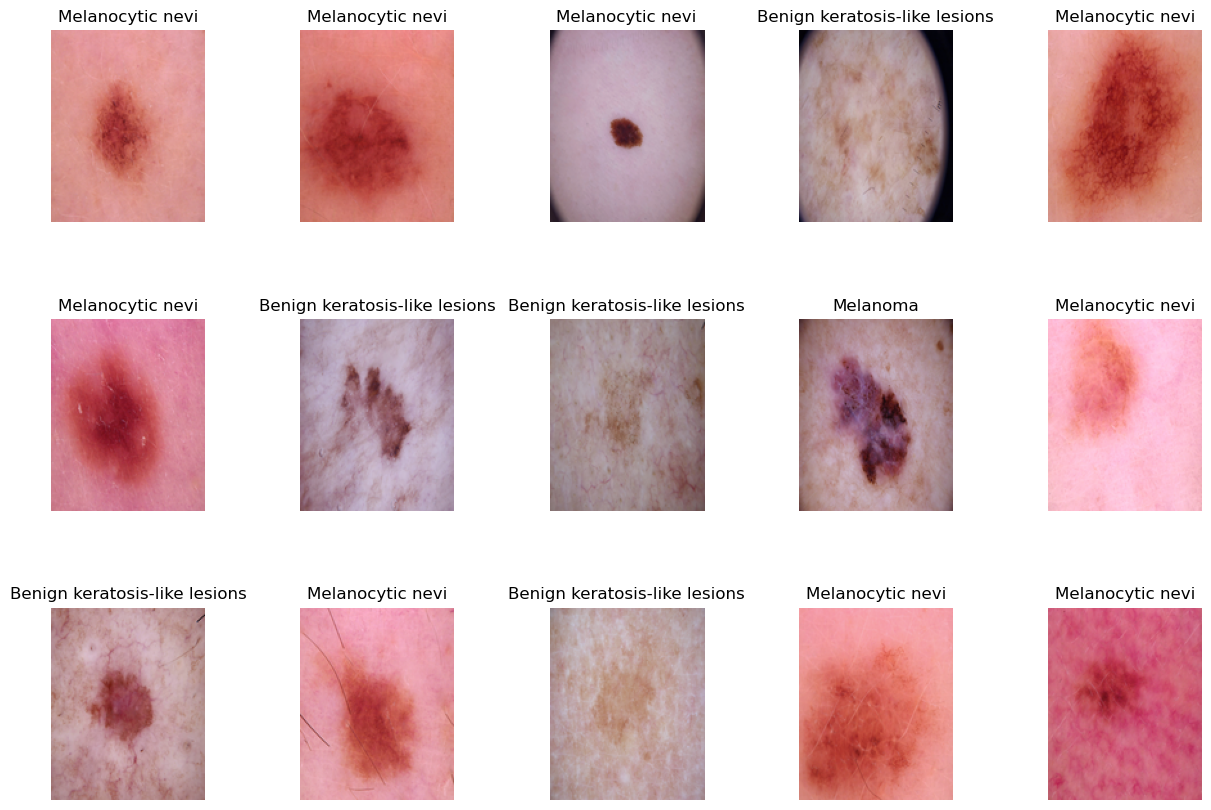

In [45]:
indice = random.sample(range(10015), 15)
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, x in enumerate(axes.flatten()):
    index1 = indices[i]
    im = data[index1]
    lab = class_labels[index1]
    x.imshow(im)
    x.set_title(lab)
    x.axis('off')

plt.show()

# Visualize Class Label Distribution

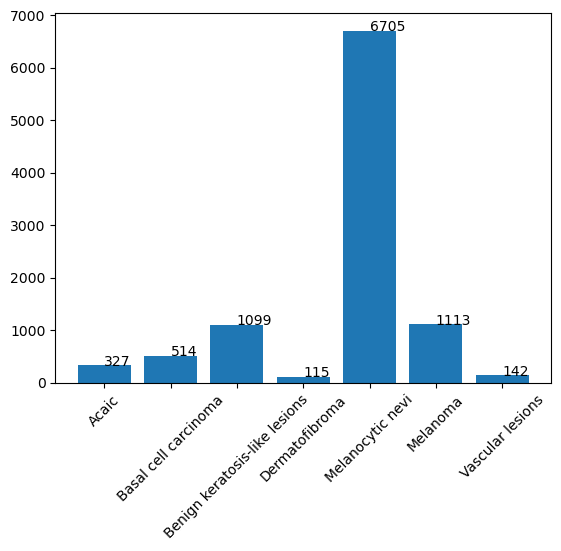

In [46]:
class_counts = {}
lab = np.unique(class_labels)
for label in lab:
    count = 0
    for i in class_labels:
        if i == label:
            count += 1
    class_counts[label] = count

labels = []
counts = []
for label, count in class_counts.items():
    labels.append(label)
    counts.append(count)

plt.bar(labels, counts)

for i in range(len(counts)):
    plt.text(labels[i], counts[i], str(counts[i]))

plt.xticks(rotation=45)
plt.show()

# Baseline Model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 118, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 116, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 56, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 69, 54, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 27, 32)       0         
 2D)                                                  

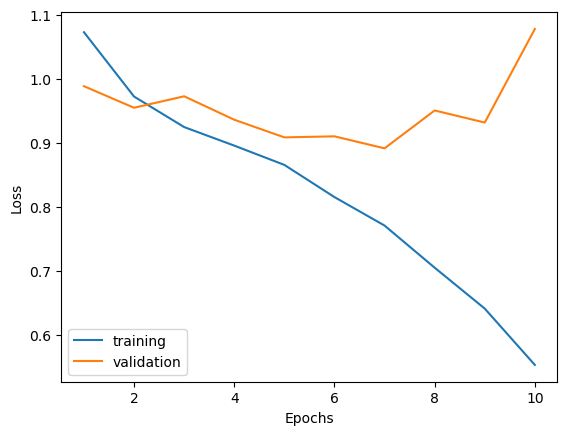

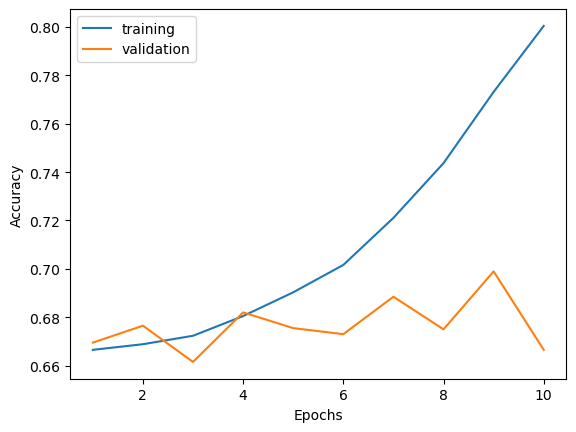

63/63 [==============================] - 7s 114ms/step


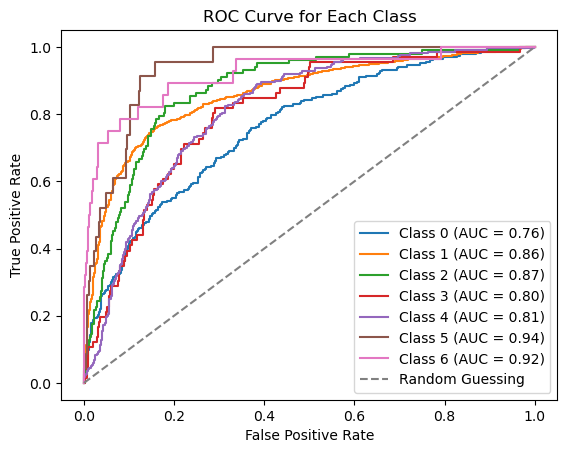

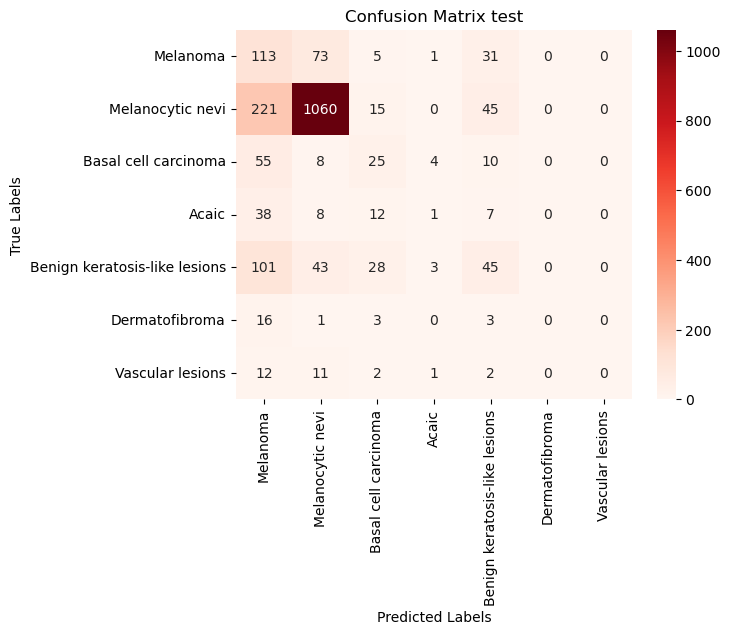

63/63 [==============================] - 7s 110ms/step


NameError: name 'y2_pred' is not defined

In [32]:

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 120, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# plotting loss 
accu = history.history['loss']
val_accu = history.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plotting ROC
y_pred = model.predict(X_test)

for i in range(7):  
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix for test set

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting the confusion matrix for validation set
y_pred = model.predict(X_val)
y2_pred = (y2_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

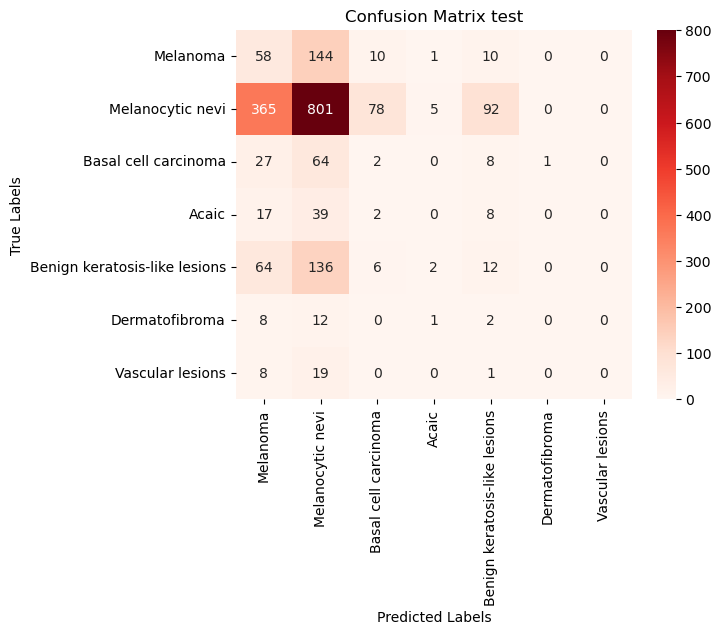

63/63 [==============================] - 5s 86ms/step


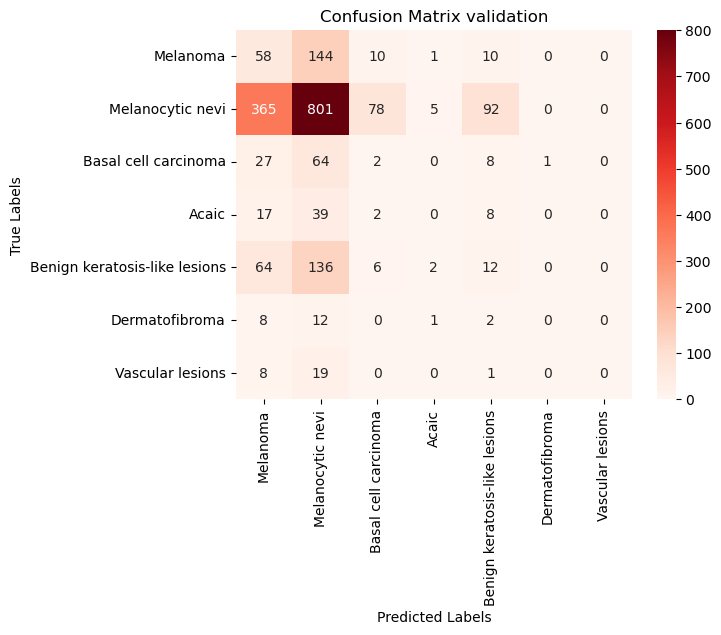

Accuracy: 0.42086869695456813
                               precision    recall  f1-score   support

                     Melanoma       0.11      0.13      0.12       223
             Melanocytic nevi       0.66      0.60      0.63      1341
         Basal cell carcinoma       0.02      0.02      0.02       102
                        Acaic       0.00      0.00      0.00        66
Benign keratosis-like lesions       0.09      0.05      0.07       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       0.00      0.00      0.00        28

                    micro avg       0.50      0.42      0.46      2003
                    macro avg       0.13      0.11      0.12      2003
                 weighted avg       0.46      0.42      0.44      2003
                  samples avg       0.42      0.42      0.42      2003



c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Plotting the confusion matrix for test set

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting the confusion matrix for validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

## Enhanced Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 118, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 116, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 58, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 54, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 27, 64)       0         
 2D)                                                    

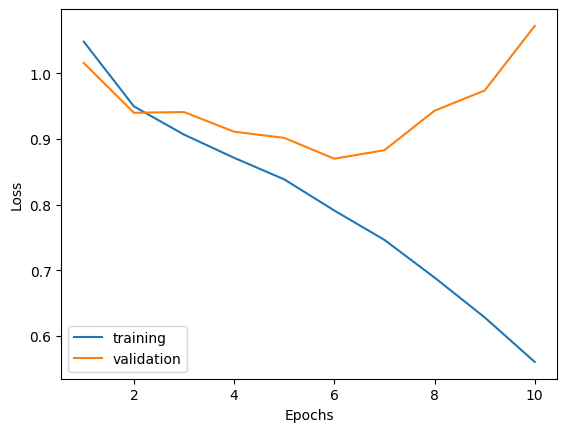

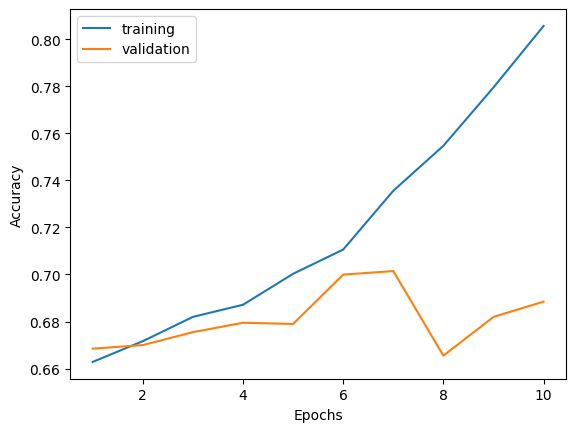

63/63 [==============================] - 1s 10ms/step


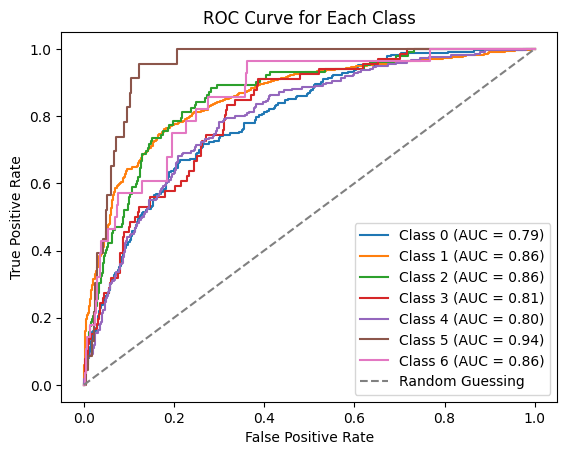

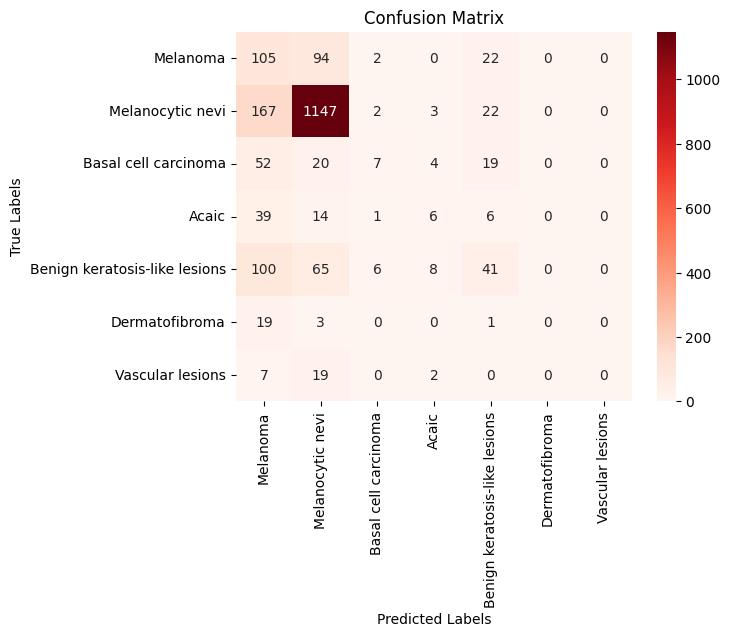

Accuracy: 0.6370444333499751
                               precision    recall  f1-score   support

                     Melanoma       0.36      0.34      0.35       223
             Melanocytic nevi       0.84      0.86      0.85      1341
         Basal cell carcinoma       0.39      0.07      0.12       102
                        Acaic       0.26      0.09      0.13        66
Benign keratosis-like lesions       0.37      0.19      0.25       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       0.00      0.00      0.00        28

                    micro avg       0.74      0.64      0.69      2003
                    macro avg       0.32      0.22      0.24      2003
                 weighted avg       0.67      0.64      0.64      2003
                  samples avg       0.64      0.64      0.64      2003



C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
# changing filter size
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2))) 

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2))) 

model1.add(layers.Flatten())
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(7, activation='softmax'))
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# plotting loss 
accu = history1.history['loss']
val_accu = history1.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = history1.history['accuracy']
val_accu = history1.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plotting ROC
y_pred = model1.predict(X_test)

for i in range(7): 
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 118, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 116, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 58, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 73, 58, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 56, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 69, 54, 64)        36928     
                                                      

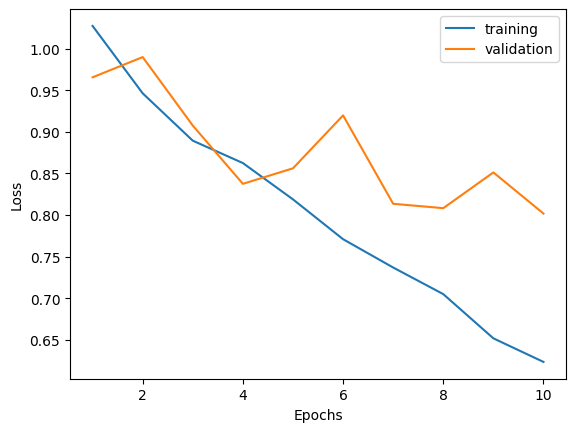

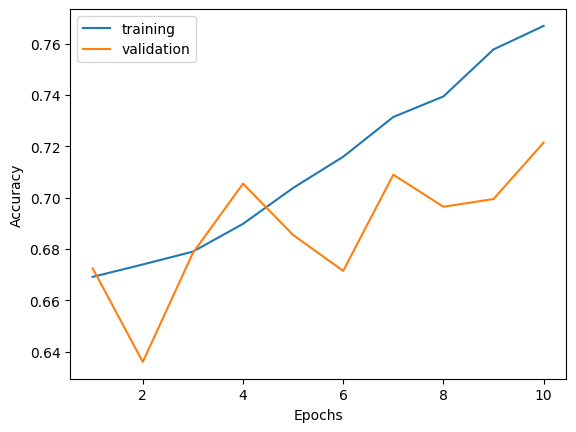

63/63 [==============================] - 1s 11ms/step


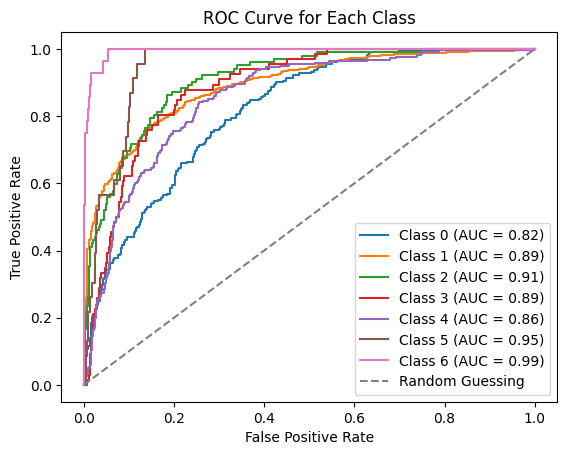

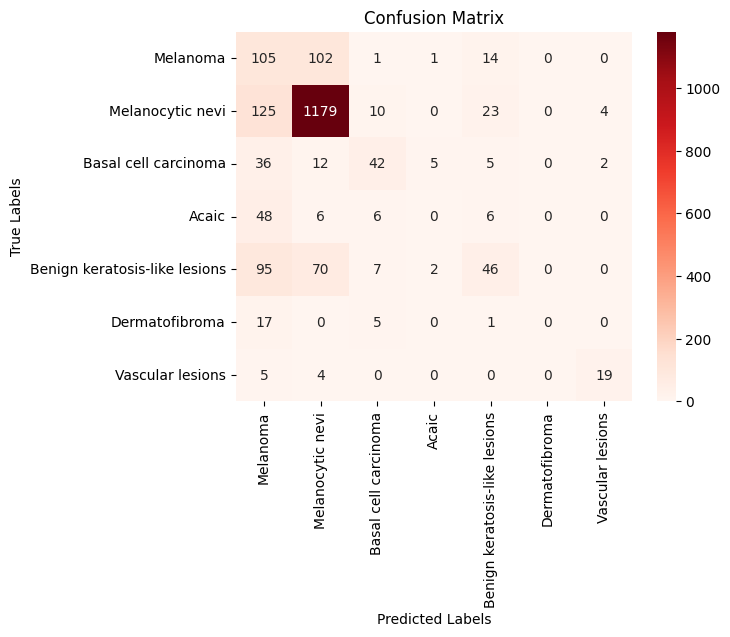

Accuracy: 0.6679980029955067
                               precision    recall  f1-score   support

                     Melanoma       0.51      0.23      0.32       223
             Melanocytic nevi       0.86      0.88      0.87      1341
         Basal cell carcinoma       0.59      0.41      0.49       102
                        Acaic       0.00      0.00      0.00        66
Benign keratosis-like lesions       0.48      0.21      0.29       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       0.76      0.68      0.72        28

                    micro avg       0.80      0.67      0.73      2003
                    macro avg       0.46      0.34      0.38      2003
                 weighted avg       0.73      0.67      0.68      2003
                  samples avg       0.67      0.67      0.67      2003



C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# drop out

model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3)))
model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2))) 
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2))) 
model3.add(layers.Dropout(0.4))

model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# plotting loss 
accu = history3.history['loss']
val_accu = history3.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = history3.history['accuracy']
val_accu = history3.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plotting ROC
y_pred = model3.predict(X_test)

for i in range(7): 
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 60, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 64)        36928     
                                                        

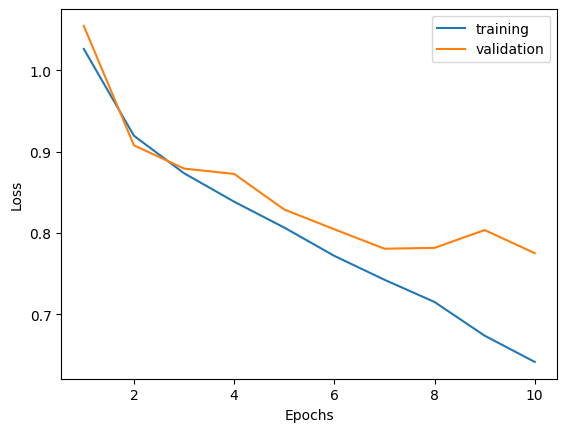

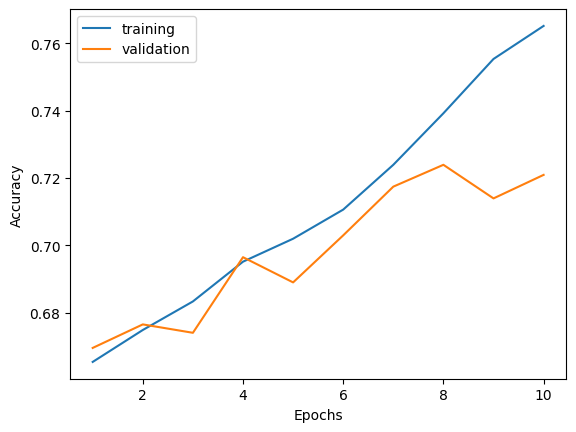

63/63 [==============================] - 1s 10ms/step


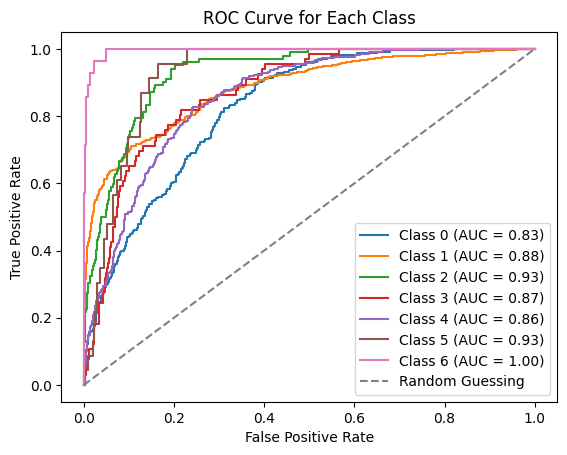

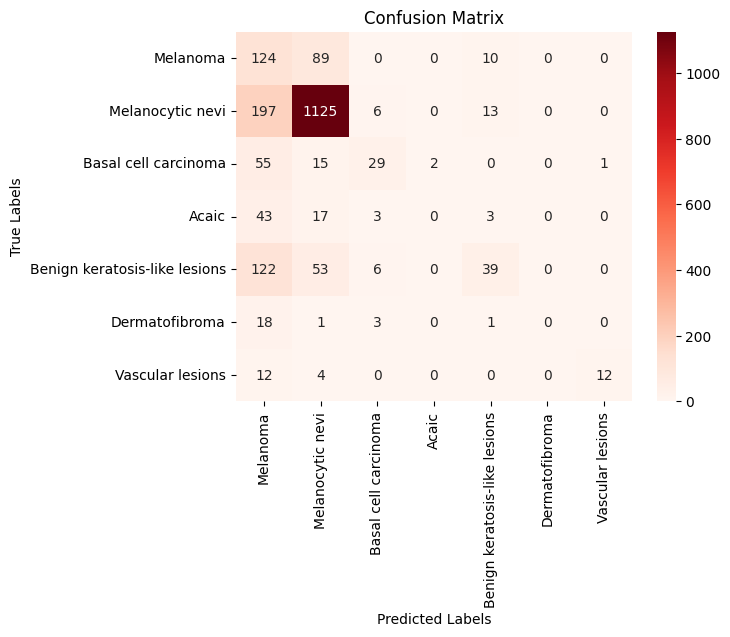

Accuracy: 0.6290564153769346
                               precision    recall  f1-score   support

                     Melanoma       0.45      0.25      0.32       223
             Melanocytic nevi       0.86      0.84      0.85      1341
         Basal cell carcinoma       0.62      0.28      0.39       102
                        Acaic       0.00      0.00      0.00        66
Benign keratosis-like lesions       0.59      0.18      0.27       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       0.92      0.43      0.59        28

                    micro avg       0.81      0.63      0.71      2003
                    macro avg       0.49      0.28      0.35      2003
                 weighted avg       0.74      0.63      0.66      2003
                  samples avg       0.63      0.63      0.63      2003



C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Igrata\anaconda3\envs\2nd\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
# padding

model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 120, 3), padding = 'same'))
model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2))) 
model4.add(layers.Dropout(0.2))

model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2))) 
model4.add(layers.Dropout(0.4))

model4.add(layers.Flatten())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(7, activation='softmax'))
model4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()

history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# plotting loss 
accu = history4.history['loss']
val_accu = history4.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = history4.history['accuracy']
val_accu = history4.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plotting ROC
y_pred = model4.predict(X_test)

for i in range(7): 
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

Epoch 1/100
188/188 [==============================] - 81s 425ms/step - loss: 1.0666 - accuracy: 0.6657 - val_loss: 0.9615 - val_accuracy: 0.6710
Epoch 2/100
188/188 [==============================] - 79s 418ms/step - loss: 0.9449 - accuracy: 0.6737 - val_loss: 0.9818 - val_accuracy: 0.6695
Epoch 3/100
188/188 [==============================] - 79s 421ms/step - loss: 0.9050 - accuracy: 0.6841 - val_loss: 0.9154 - val_accuracy: 0.6870
Epoch 4/100
188/188 [==============================] - 81s 430ms/step - loss: 0.8716 - accuracy: 0.6873 - val_loss: 0.8590 - val_accuracy: 0.6905
Epoch 5/100
188/188 [==============================] - 76s 402ms/step - loss: 0.8429 - accuracy: 0.6948 - val_loss: 0.8798 - val_accuracy: 0.6745
Epoch 6/100
188/188 [==============================] - 79s 419ms/step - loss: 0.8241 - accuracy: 0.7021 - val_loss: 0.8520 - val_accuracy: 0.6880
Epoch 7/100
188/188 [==============================] - 77s 410ms/step - loss: 0.8057 - accuracy: 0.7068 - val_loss: 0.8577 -

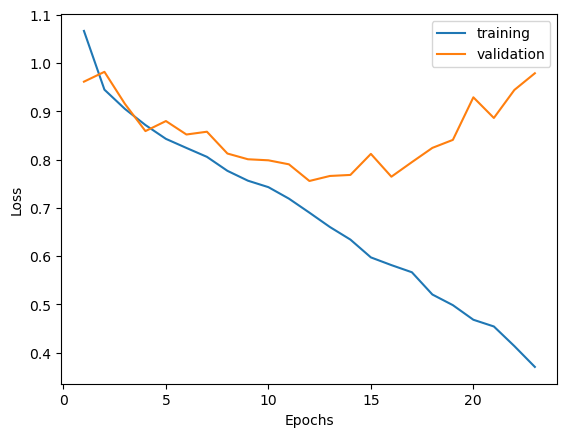

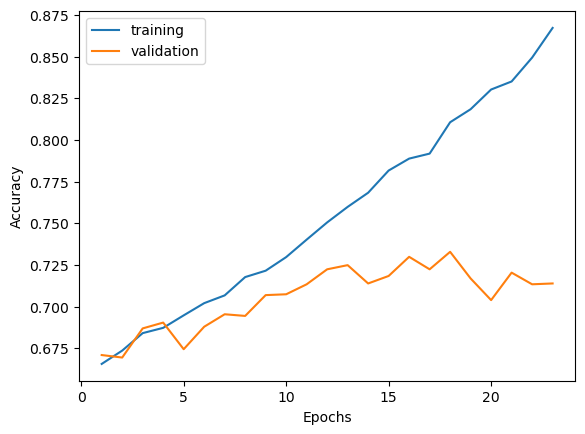

63/63 [==============================] - 6s 93ms/step


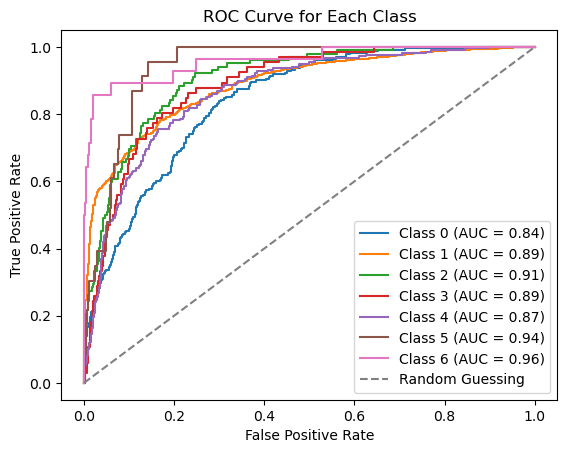

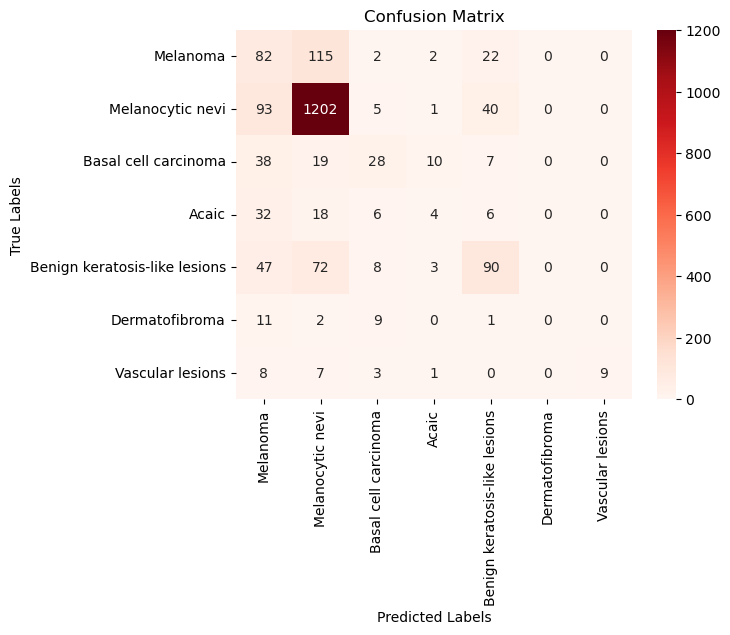

Accuracy: 0.6894658012980529
                               precision    recall  f1-score   support

                     Melanoma       0.58      0.22      0.31       223
             Melanocytic nevi       0.84      0.90      0.87      1341
         Basal cell carcinoma       0.46      0.27      0.34       102
                        Acaic       0.19      0.06      0.09        66
Benign keratosis-like lesions       0.54      0.41      0.47       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       1.00      0.32      0.49        28

                    micro avg       0.78      0.69      0.73      2003
                    macro avg       0.52      0.31      0.37      2003
                 weighted avg       0.73      0.69      0.69      2003
                  samples avg       0.69      0.69      0.69      2003



c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# early stopping


early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True )

history40 = model4.fit(X_train, y_train,epochs=100, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping]) 

# plotting loss 
accu = history40.history['loss']
val_accu = history40.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = history40.history['accuracy']
val_accu = history40.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plotting ROC
y_pred = model4.predict(X_test)

for i in range(7): 
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)

## Transfer Learning Model

In [11]:
# transfer learning

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 120, 3))

for layer in base_model.layers:
    layer.trainable = False

modelt = Sequential()
modelt.add(base_model)
modelt.add(Flatten())
modelt.add(Dense(64, activation = 'relu'))
modelt.add(Dense(7, activation = 'softmax'))
modelt.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

modelt.summary()

historyt = modelt.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 6144)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                393280    
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 15,108,423
Trainable params: 393,735
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
188/188 [==============================] - 222s 1s/step - loss: 0.9278 - accuracy: 0.6885 - val_loss: 0.8226 - val_accuracy: 0.7124
Epoch 2/10
188/188 [=====

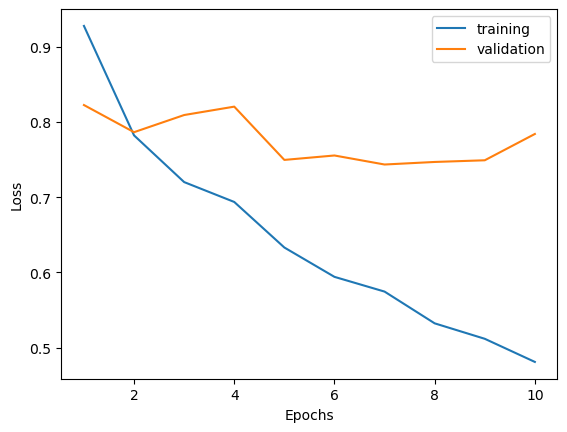

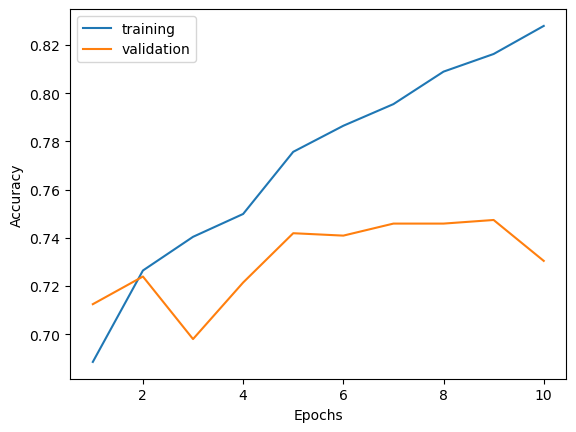

63/63 [==============================] - 56s 885ms/step


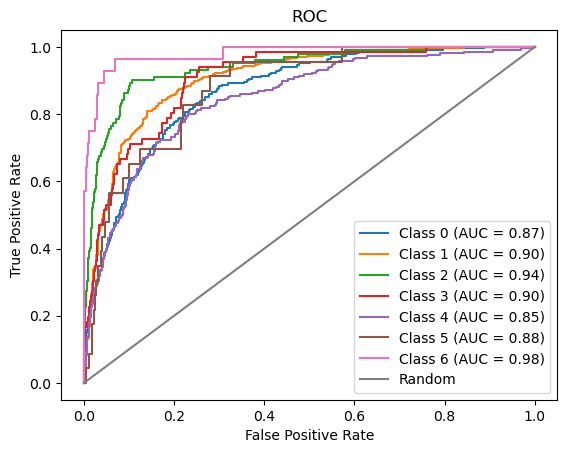

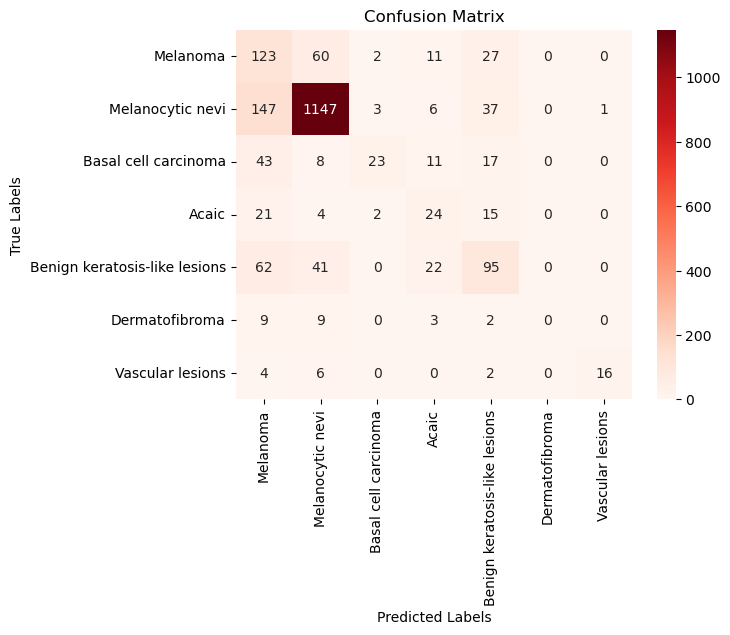

Accuracy: 0.6824762855716425
                               precision    recall  f1-score   support

                     Melanoma       0.64      0.28      0.39       223
             Melanocytic nevi       0.90      0.86      0.88      1341
         Basal cell carcinoma       0.77      0.23      0.35       102
                        Acaic       0.31      0.36      0.34        66
Benign keratosis-like lesions       0.49      0.43      0.46       220
               Dermatofibroma       0.00      0.00      0.00        23
             Vascular lesions       0.94      0.57      0.71        28

                    micro avg       0.81      0.68      0.74      2003
                    macro avg       0.58      0.39      0.45      2003
                 weighted avg       0.79      0.68      0.72      2003
                  samples avg       0.68      0.68      0.68      2003



c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3-2023.03\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# plotting loss 
accu = historyt.history['loss']
val_accu = historyt.history['val_loss']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# Plotting accuracy
accu = historyt.history['accuracy']
val_accu = historyt.history['val_accuracy']

plt.plot(range(1, len(accu) + 1), accu)
plt.plot(range(1, len(val_accu) + 1), val_accu)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

#plotting ROC
y_pred = modelt.predict(X_test)

for i in range(7):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Plotting the confusion matrix

y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
class_labels = ["Melanoma", 'Melanocytic nevi', "Basal cell carcinoma", "Acaic","Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Accuracy
ac = accuracy_score(y_test, y_pred)

#Classification Report
report = classification_report(y_test, y_pred, target_names=class_labels)

print("Accuracy:", ac)
print(report)